In [1]:
import sys
from os import listdir
from os.path import isfile, join
import string

import numpy as np
from plot_solution import plot_solution
import matplotlib.pyplot as plt 

from ioutils import parse_input
from utils import get_distance_matrix
from utils import get_discount_matrix
from utils import allocate_paths
from utils import get_total_cost
from utils import get_flow_from_paths
import cplex_utils
import graph_utils as graph_utils

In [2]:
DATASET = 'AP'
INPUT_DIRECTORY = "./data/AP/"

In [3]:
files = [join(INPUT_DIRECTORY, f) for f in listdir(INPUT_DIRECTORY) if isfile(join(INPUT_DIRECTORY, f))]
print(files)
file = files[5]
print(file)

['./data/AP/10.3', './data/AP/20.3', './data/AP/50.3', './data/AP/10.2', './data/AP/ReadMe-UMApHMP.txt', './data/AP/5.3', './data/AP/25.3', './data/AP/10.5', './data/AP/100.3', './data/AP/200.3', './data/AP/10.4', './data/AP/40.3', './data/AP/Solutions-UMApHMP.txt']
./data/AP/5.3


In [4]:
n, p, alpha, delta, ksi, nodes_coordinates, demand = parse_input(file, DATASET)
distances = get_distance_matrix(nodes_coordinates)

In [5]:
distances

array([[    0.        , 13938.53353687, 21060.79487553, 28449.4743405 ,
        32766.53105743],
       [13938.53353687,     0.        ,  7459.76692478, 14529.05636314,
        18844.74831806],
       [21060.79487553,  7459.76692478,     0.        ,  7732.22329872,
        12496.67358212],
       [28449.4743405 , 14529.05636314,  7732.22329872,     0.        ,
         4866.63714485],
       [32766.53105743, 18844.74831806, 12496.67358212,  4866.63714485,
            0.        ]])

In [6]:
demand

array([[176.61665, 125.34769,  79.20234, 132.42473,  64.29719],
       [156.57673, 117.26395,  84.0084 , 154.1076 ,  72.5144 ],
       [ 72.67156,  68.55955,  69.84654, 152.49323,  70.94659],
       [236.78537, 242.95594, 260.98275, 674.40462, 353.4268 ],
       [ 70.77734,  76.18147,  86.06981, 242.88428, 137.56972]])

In [7]:
M, X, Y, Z, H = cplex_utils.get_umaphmp_model(n, p, alpha, delta, ksi, distances, demand, formulation='EK', verbose=True)
solution = M.solve(log_output=True)
hubs_bit_mask = [int(solution.get_var_value(H[i])) for i in range(n)]
cplex_objective = round(solution.objective_value, 7)

[2023-07-23 14:25:32,213] Created model M
[2023-07-23 14:25:32,217] Defined variables X
[2023-07-23 14:25:32,221] Defined variables Y
[2023-07-23 14:25:32,222] Defined variables Z
[2023-07-23 14:25:32,224] Defined variables H
[2023-07-23 14:25:32,224] Defined constraints (2)
[2023-07-23 14:25:32,226] Defined constraints (3)
[2023-07-23 14:25:32,228] Defined constraints (4)
[2023-07-23 14:25:32,233] Defined constraints (5)
[2023-07-23 14:25:32,237] Defined constraints (6)
[2023-07-23 14:25:32,241] Defined constraints (7)
[2023-07-23 14:25:32,244] Defined constraints (1)


Version identifier: 22.1.1.0 | 2022-11-28 | 9160aff4d
CPXPARAM_Read_DataCheck                          1
Tried aggregator 1 time.
MIP Presolve eliminated 0 rows and 25 columns.
Reduced MIP has 106 rows, 255 columns, and 705 nonzeros.
Reduced MIP has 5 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.23 ticks)
Found incumbent of value 3.2008180e+08 after 0.01 sec. (0.55 ticks)
Probing time = 0.00 sec. (0.02 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 106 rows, 255 columns, and 705 nonzeros.
Reduced MIP has 5 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.29 ticks)
Probing time = 0.00 sec. (0.02 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 sec. (0.27 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    B

In [8]:
Z_allocated = {(i,k): solution.get_var_value(Z[i,k]) for i in range(n) for k in range(n)}
X_allocated = {(i,l,j): solution.get_var_value(X[i,l,j]) for i in range(n) for l in range(n) for j in range(n)}
Y_allocated = {(i,k,l): solution.get_var_value(Y[i,k,l]) for i in range(n) for k in range(n) for l in range(n)}
cplex_flow = cplex_utils.get_flow_from_XYZ(n, X_allocated, Y_allocated, Z_allocated)

In [9]:
hubs, = np.where(hubs_bit_mask)
hubs

array([0, 1, 3])

In [10]:
discounts = get_discount_matrix(n, hubs, alpha, delta, ksi)
discounts

array([[0.75, 0.75, 2.  , 0.75, 2.  ],
       [0.75, 0.75, 2.  , 0.75, 2.  ],
       [3.  , 3.  , 1.  , 3.  , 1.  ],
       [0.75, 0.75, 2.  , 0.75, 2.  ],
       [3.  , 3.  , 1.  , 3.  , 1.  ]])

In [11]:
paths = allocate_paths(n, hubs, distances, discounts)
paths

[[0, 1],
 [0, 1, 2],
 [0, 3],
 [0, 3, 4],
 [1, 0],
 [1, 2],
 [1, 3],
 [1, 3, 4],
 [2, 1, 0],
 [2, 1],
 [2, 3],
 [2, 3, 4],
 [3, 0],
 [3, 1],
 [3, 2],
 [3, 4],
 [4, 3, 0],
 [4, 3, 1],
 [4, 3, 2],
 [4, 3],
 [2, 1, 2],
 [4, 3, 4]]

In [15]:
vns_flow = get_flow_from_paths(n, paths, demand)
vns_flow

array([[  0.     , 204.55003,   0.     , 196.72192,   0.     ],
       [229.24829,   0.     , 233.05728, 226.622  ,   0.     ],
       [  0.     , 211.07765,   0.     , 223.43982,   0.     ],
       [307.56271, 319.13741, 347.05256,   0.     , 698.7547 ],
       [  0.     ,   0.     ,   0.     , 613.48262,   0.     ]])

In [16]:
list(cplex_flow)

[array([1291.31625,  204.55003,    0.     ,  196.72192,    0.     ]),
 array([ 229.24829, 1214.77968,  233.05728,  226.622  ,    0.     ]),
 array([  0.     , 211.07765,   0.     , 223.43982,   0.     ]),
 array([ 307.56271,  319.13741,  347.05256, 3124.86994,  698.7547 ]),
 array([  0.     ,   0.     ,   0.     , 613.48262,   0.     ])]

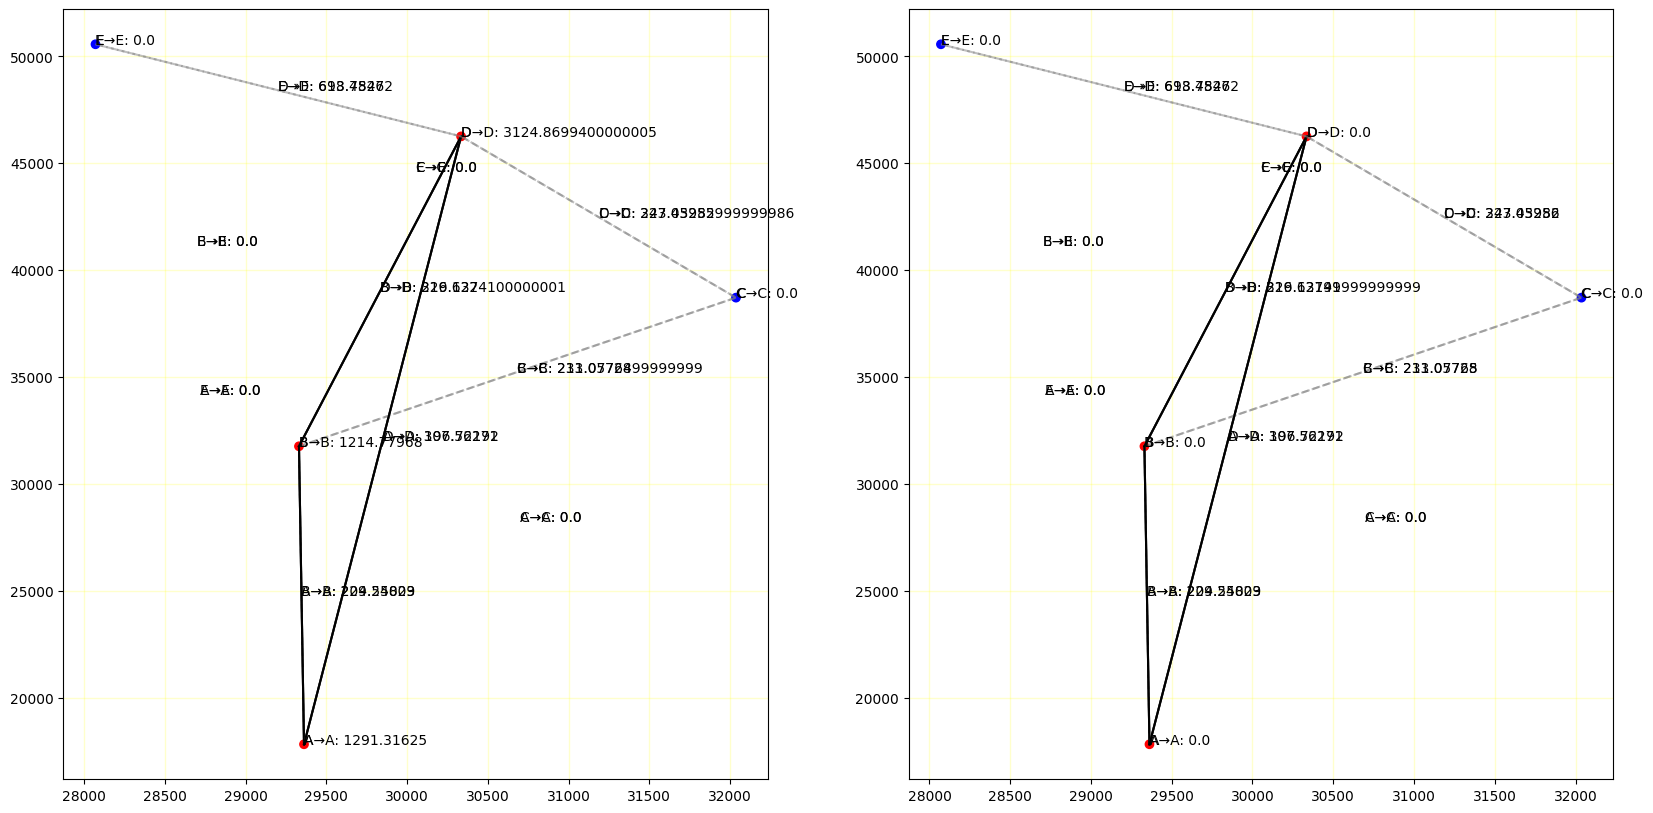

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
alphabet = list(string.ascii_uppercase)
plot_solution(ax1, nodes_coordinates, alphabet[:n], hubs_bit_mask, cplex_flow, plot_all_lines=False, verbose=1)
plot_solution(ax2, nodes_coordinates, alphabet[:n], hubs_bit_mask, vns_flow, plot_all_lines=False, verbose=1)
plt.show()


In [18]:
get_total_cost(vns_flow, distances, discounts)

55750760.52196098

In [19]:
get_total_cost(cplex_flow, distances, discounts)

55750760.521960974

In [20]:
cplex_objective

55750760.521961